# Plot some Survival curves


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.colors import LogNorm
#import scipy.sparse.linalg as sla

from scipy.integrate import odeint


sns.set_context("talk", font_scale=1.4)

from lifelines import KaplanMeierFitter




In [11]:
# Load the time series for plotting empirical distributions
timeSeries = pd.read_excel('./../data/polity5/p5v2018.xls')
# do some cleaning
timeSeries = timeSeries.dropna(subset=['year', 'country', 'polity2'])

In [3]:
# load the inferred transition matrix
P_allCountries_Bayes = np.genfromtxt('./../results/transitionBayesAllCountries.csv')

## Look at prediction starting from different years

In [6]:

def estimateTransitionMatrix(data,approach='frequentist'):
    
    # construct some output matrices
    countMatrix=np.zeros((21,21)) # empty transition matrix
    
    # split the timeseries into one for each country 
    uniqueCountries = data['country'].unique()
    countryTimeseries =[]
    
    # count for each country the transitions
    for country in uniqueCountries:
        sortedPolity2Country = data[data['country'] == country].sort_values(by='year')["polity2"].tolist()
        T=len(sortedPolity2Country)# number of data points
        for t in range(T-1): # go over all years
            fromTransition = int(sortedPolity2Country[t] + 10)
            toTransition = int(sortedPolity2Country[t+1] + 10)
            
            if  (fromTransition>=0) and ((toTransition>=0)):
                
                # increase the count for this year
                countMatrix[fromTransition,toTransition] = countMatrix[fromTransition,toTransition] + 1
    
    if approach=='frequentist':
        # compute the transition probabilities as count over total outgoing
        P = countMatrix/countMatrix.sum(axis=1)[:,None]
    if approach=='bayesian':
        # we use a Dirichlet prior for each row
        priorMatrix = np.zeros((21,21)) + 1/21
        combinedMatrix = countMatrix + priorMatrix
        # this is the posterior mean
        P = combinedMatrix/combinedMatrix.sum(axis=1)[:,None]
    
    return(P)

In [28]:
def distributionsForYear(timeSeriesData,year):
    currentScores=timeSeriesData[timeSeriesData['year']==year]['polity2']
    [countsYear,bins] = np.histogram(currentScores,bins=np.arange(-10,12))
    densityYear = countsYear/np.sum(countsYear)
    return(densityYear)

def predictionFromYear(data,year,yearsInFuture):
    # subset the data
    data = data[data['year']<=year]
    # estimate transition matrix
    P_temp = estimateTransitionMatrix(data,approach='bayesian')
    # compute the starting distirbutions
    x=np.zeros((21,yearsInFuture))
    x[:,0]=distributionsForYear(data,year)
    #  compute the transitions
    for t in np.arange(yearsInFuture-1):
        x[:,t+1]= x[:,t].dot(P_temp)
        
    return(x)

def summariseStates(x):
    autocraty = np.sum(x[0:10,:],axis=0)
    fullDemocracy = x[20,:]
    partialDemocracy = np.sum(x[10:19,:],axis=0)
    
    return([autocraty,fullDemocracy,partialDemocracy])

def calculateRMSE(timeSeries,year,predictionMethod='markov'):
    
    # calculate the distribution for the future years
    # compare with actual development
    yearsHistoric = np.arange(year,2018,1)
    historicDistributions = np.zeros((21,len(yearsHistoric)))
    i=0
    for y in yearsHistoric:
        historicDistributions[:,i] = distributionsForYear(timeSeries,y)
        i=i+1
        
        
    # do the prediction 
    if predictionMethod == 'markov':
        # do the prediction
        yearInFuture = 2018-year
        xYear = predictionFromYear(timeSeries,year,yearInFuture)
        # summarise
        errorMatrix = (historicDistributions-xYear)**2
        error=np.sqrt(np.sum(errorMatrix,axis=0)/21)
    if predictionMethod == 'stationary':
        xYearStationary = np.zeros((21,len(yearsHistoric)))
        i=0
        for y in yearsHistoric:
            xYearStationary[:,i] = historicDistributions[:,0]
            i=i+1
        # summarise
        errorMatrix = (historicDistributions-xYearStationary)**2
        error=np.sqrt(np.sum(errorMatrix,axis=0)/21)
    if predictionMethod == 'uniform':
        xYearUniform = np.zeros((21,len(yearsHistoric)))
        i=0
        for y in yearsHistoric:
            uniformDistribution = np.ones(21)
            xYearUniform[:,i] = uniformDistribution/np.sum(uniformDistribution)
            i=i+1
        # summarise
        errorMatrix = (historicDistributions-xYearUniform)**2
        error=np.sqrt(np.sum(errorMatrix,axis=0)/21)
    if predictionMethod == 'EoH':
        xYearEoH = np.zeros((21,len(yearsHistoric)))
        i=0
        for y in yearsHistoric:
            onlyFullDemocracies = np.zeros(21)
            onlyFullDemocracies[20] = 1
            xYearEoH[:,i] = onlyFullDemocracies
            i=i+1
        # summarise
        errorMatrix = (historicDistributions-xYearEoH)**2
        error=np.sqrt(np.sum(errorMatrix,axis=0)/21)
        
    return(error)

In [29]:
# average this for all years 1900 until 2000
yearsInFuture=75

maxYear = 2018-yearsInFuture
yearVec = np.arange(1850,maxYear)
nYear = len(yearVec)




# save the error for 30 years in future
errorOut = np.empty((nYear,yearsInFuture))
errorOut[:] = np.NaN
errorOutStationary = np.empty((nYear,yearsInFuture))
errorOutStationary[:] = np.NaN
errorOutUniform = np.empty((nYear,yearsInFuture))
errorOutUniform[:] = np.NaN
errorOutEoH = np.empty((nYear,yearsInFuture))
errorOutEoH[:] = np.NaN


i=0
for year in yearVec:
    yearInFutureAdjusted = np.min([2018 - year,yearsInFuture])
    
    error = calculateRMSE(timeSeries,year)
    errorStationary = calculateRMSE(timeSeries,year,predictionMethod = 'stationary')
    errorUniform = calculateRMSE(timeSeries,year,predictionMethod = 'uniform')
    errorEoH = calculateRMSE(timeSeries,year,predictionMethod = 'EoH')
    
    errorOut[i,0:yearInFutureAdjusted] =  error[0:yearInFutureAdjusted]
    errorOutStationary[i,0:yearInFutureAdjusted] =  errorStationary[0:yearInFutureAdjusted]
    errorOutUniform[i,0:yearInFutureAdjusted] =  errorUniform[0:yearInFutureAdjusted]
    errorOutEoH[i,0:yearInFutureAdjusted] =  errorEoH[0:yearInFutureAdjusted]
    
    
    i=i+1

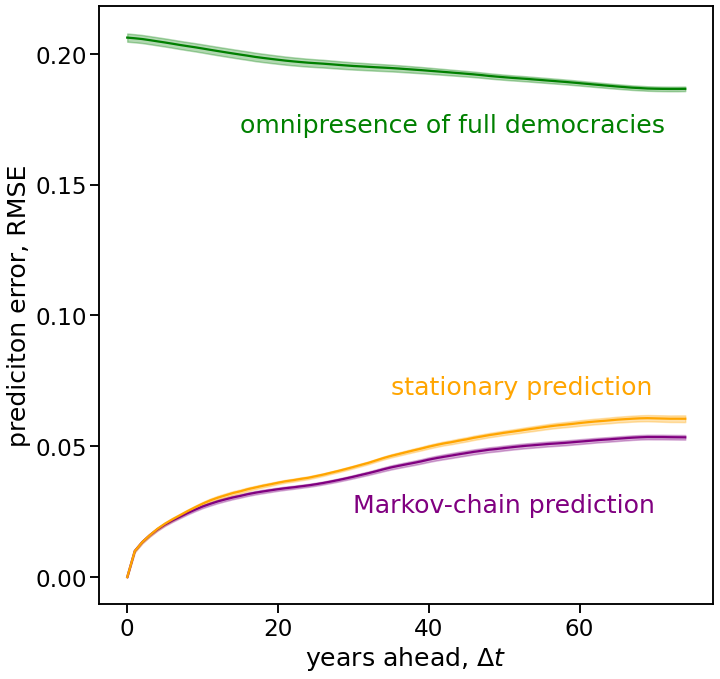

In [33]:
def plotWithErrorShade(y,color='k'):
    
    n = errorOut.shape[0]
    
    mean = np.nanmean(y,axis=0)
    std = np.nanstd(y,axis=0)/np.sqrt(n)
    x = np.arange(0,len(mean))
    
    plt.plot(x, mean, '-',color=color)
    plt.fill_between(x, mean-std, mean+std,alpha=0.3,color=color)

plt.figure(figsize=(11,11))  
plotWithErrorShade(errorOut,color='purple')
plotWithErrorShade(errorOutStationary,color='orange')

plotWithErrorShade(errorOutEoH,color='green')


plt.text(x=15,y=0.17,s='omnipresence of full democracies',color='green')
plt.text(x=30,y=0.025,s='Markov-chain prediction',color='purple')
plt.text(x=35,y=0.07,s='stationary prediction',color='orange')


plt.ylabel('prediciton error, RMSE')
plt.xlabel(r'years ahead, $\Delta t$')
plt.savefig('./../results/figures/Fig7-predictionRMSE.pdf')
